In [1]:
#https://www.kaggle.com/code/lxyuan0420/facial-expression-recognition-using-cnn

#import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("data"))


['Blood_fat1.csv', 'Blood_fat2.csv', 'Blood_fat3.csv', 'fer2013.csv', '.DS_Store', 'add_class.csv', 'merge.csv', 'logs', 'model']


In [3]:
#dataset
data = pd.read_csv('data/fer2013.csv')

#check data shape
data.shape

(35887, 3)

In [4]:
#preview first 5 row of data
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
#check usage values
#80% training, 10% validation and 10% test
data.Usage.value_counts()


Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [6]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
#emotion별 data 개수 확인
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
#data 개수 확인 도식화
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts



,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


/Users/soyeonjung/miniforge3/envs/tf25/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


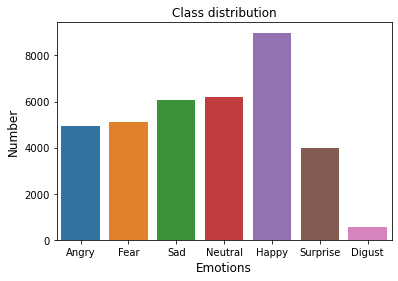

In [7]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()


/var/folders/96/pt5lmkjx2_351y1mch4tfz2c0000gn/T/ipykernel_8925/684817139.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


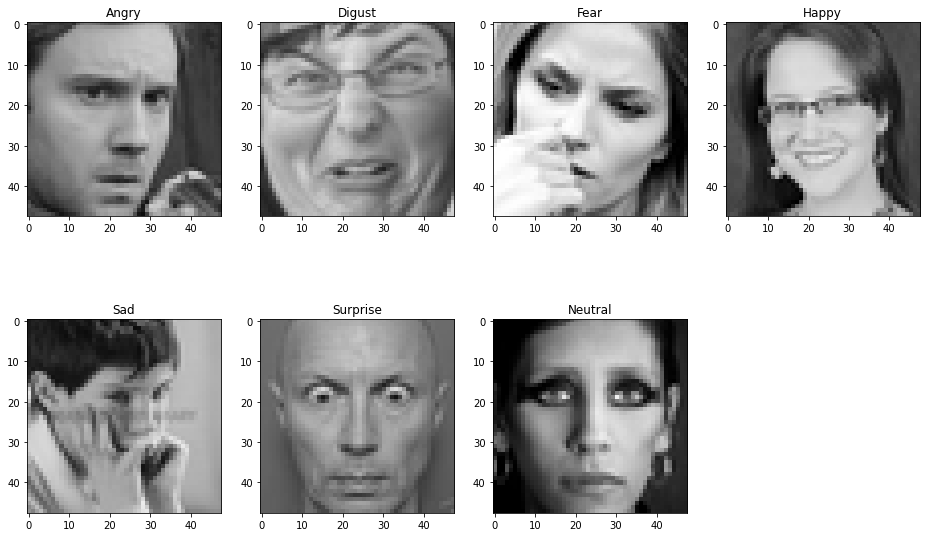

In [40]:
#각 표정별 대표 이미지 하나씩 확인

#pixel data를 reshape하여 image로 보여줌
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    #2차원의 img 3장으로 3차원 image를 만듦
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    #iloc: integer location-데이터 프레임의 행이나 칼럼의 순서를 나타내는 정수 
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    #3차원의 그림중 첫번째 층만 show
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

In [9]:
#split data into 3parts: training, validation, test set

#Training: 모델을 학습하는데 사용
#PublicTest -> validation set: 모델의 성능을 측정하기 위해 사용, 성능이 가장 좋았던 모델 선택
#PrivateTest -> 해당 모델의 예상되는 성능을 측정하기 위해 사용

data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))


train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


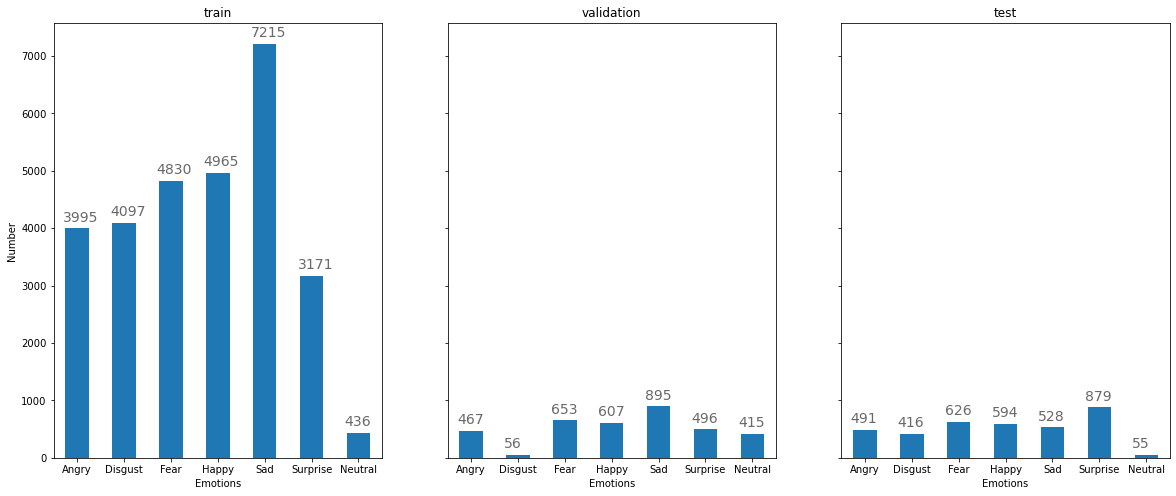

In [41]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()


In [11]:
#initilize parameters
num_classes = 7 #class(emotion)의 개수가 7개
width, height = 48, 48 #48*48 pixels image
num_epochs = 50 #학습되는 epochs 수
batch_size = 64 #하나의 소그룹에 속하는 데이터 수
num_features = 64 #이미지에서 뽑아낼 특징의 개수

In [12]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data


train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [48]:
#Building CNN Model
# Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
# Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
# Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
# Flatten
# Dense -> BN -> Activation
# Dense -> BN -> Activation
# Dense -> BN -> Activation
# Output layer


model = Sequential()

# module1, module2, module3
# : Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
# Conv2D
# 48*48의 image에 3*3의 filter(kernel)을 적용하여 2*2*64개의 hidden layer를 만듦
# BN(Batch Normalization)
# 다양한 분포를 가지는 데이터를 각 batch 별로 평균과 분산을 이용하여 정규화 시킴
# Activation(Relu_Rectified Linear Unit)
# 0미만은 0, 0이상은 f(x)값 그대로
# MaxPooling2D(input size줄임, overfitting조절)
# 정해진 크기 안에서 가장 큰 값(특징)을 뽑아냄

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten
# 다차원 배열을 1차원으로 풀어서 나열

#flatten
model.add(Flatten())

# Dense1, dense2, dense3
# : Dense -> BN -> Activation
# Dense Layer: 추출된 정보들을 하나의 layer로 모으고, 원하는 차원으로 축소시켜서 표현
# 2*2*2*64- > 2*2*64 -> 2*64

#dense 1
model.add(Dense(2*2*2*num_features)) #Dense 함수에 activation을 정의하지 않을 때 default?
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Output layer
# Dense layer -> 7
# Softmax
# 입력받은 값을 출력으로 0~1사이의 값으로 모두 정규화, 출력 값들의 총합은 1

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization_9 (Batc  (None, 46, 46, 256)      1024      
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 46, 46, 256)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_10 (Bat  (None, 46, 46, 256)      1024      
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 46, 46, 256)      

/Users/soyeonjung/miniforge3/envs/tf25/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# data generator

#이미지를 학습시킬 때 학습데이터의 양이 적을 경우 학습데이터를 조금씩 변형시켜서 사용
#featurewise_center = False: 데이터셋에 대해 특성별로 input의 평균이 0이 되도록 하지 않음
#featurewise_std_normalization = False: 각 샘플의 평균이 0이 되도록 하지 않음
#rotation_range = 무작위 회전각도 10도 이내
#width_shift_range: 사진을 좌위로 이동
#height_shift_range: 사진을 상하로 이동
#zoom_range: 이미지를 확대 또는 축소
#horizontal_flip=True : 무작위로 가로로 뒤짚기
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

# 모델 저장 폴더 설정
MODEL_DIR = 'data/model3'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
# 모델 저장 조건 설정
modelpath = 'data/model3/{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath,
                               monitor="val_loss",
                               verbose=1,
                               save_best_only=True)

#fit과 fit_generator의 차이: fit-데이터 x와 y의 전체를 한번에 입력으로 사용, fit-generator: 대용량의 데이터를 효율적으로 학습, batch-by-batch로 학습
#steps_per_epoch: weight와 bias가 업데이트 횟수 확인
#data_generator.flow(): 이미지 변형 완료
history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))


model.save('data/model3/best_model.hdf5')


Epoch 1/50


/var/folders/96/pt5lmkjx2_351y1mch4tfz2c0000gn/T/ipykernel_8925/1137812640.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),


448/448 - 92s - loss: 0.6538 - accuracy: 0.7535 - val_loss: 1.0519 - val_accuracy: 0.6478 - 92s/epoch - 204ms/step
Epoch 2/50
448/448 - 91s - loss: 0.6482 - accuracy: 0.7572 - val_loss: 1.0969 - val_accuracy: 0.6378 - 91s/epoch - 203ms/step
Epoch 3/50
448/448 - 90s - loss: 0.6379 - accuracy: 0.7624 - val_loss: 1.0760 - val_accuracy: 0.6562 - 90s/epoch - 200ms/step
Epoch 4/50
448/448 - 89s - loss: 0.6275 - accuracy: 0.7646 - val_loss: 1.0168 - val_accuracy: 0.6520 - 89s/epoch - 199ms/step
Epoch 5/50
448/448 - 89s - loss: 0.6153 - accuracy: 0.7670 - val_loss: 1.0166 - val_accuracy: 0.6601 - 89s/epoch - 199ms/step
Epoch 6/50
448/448 - 90s - loss: 0.6126 - accuracy: 0.7707 - val_loss: 1.0453 - val_accuracy: 0.6573 - 90s/epoch - 200ms/step
Epoch 7/50
448/448 - 91s - loss: 0.6032 - accuracy: 0.7728 - val_loss: 1.1012 - val_accuracy: 0.6456 - 91s/epoch - 203ms/step
Epoch 8/50
448/448 - 91s - loss: 0.5904 - accuracy: 0.7797 - val_loss: 1.1126 - val_accuracy: 0.6556 - 91s/epoch - 202ms/step
Epo

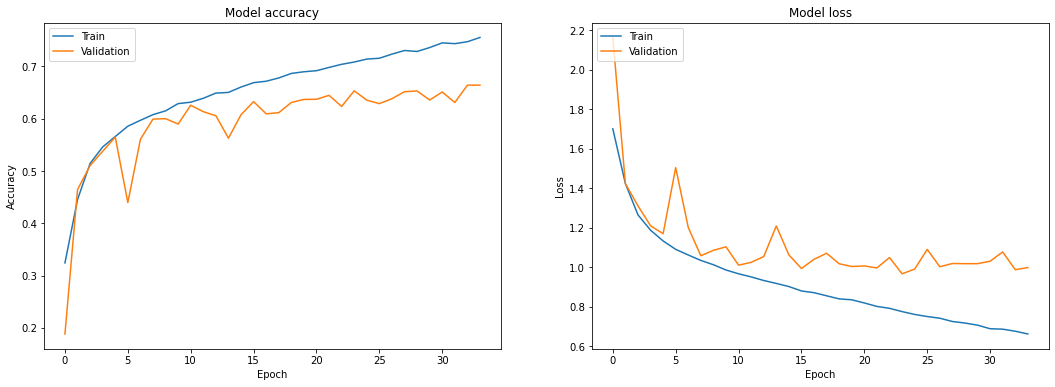

In [22]:
#Visualize Training Performance

#기존 코드 acc(error 확인) -> 변경 코드 accuracy

fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [38]:
#Evaluate Test Performance

#accuracy_score-sklearn 함수
#분류 모델의 학습성능을 평가하는 방법

test_true = np.argmax(test_Y, axis=1) #실제값
test_pred = np.argmax(model.predict(test_X), axis=1) #예측값
print(test_true)
print(test_pred)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))


113/113 [==============================] - 3s 28ms/step
[0 5 6 ... 0 3 2]
[0 4 4 ... 6 3 4]
CNN Model Accuracy on test set: 0.6623


In [36]:
#More Analysis using Confusion Matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #title이 false일 때 실행
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    
    if normalize:
        #백분율로 보기위해 정규화 계산
        #axis=1: y축(True label)값을 기준으로 한 sum의 합이 1
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    #fig: 그림, ax: 그림에 그려질 그래프
    fig, ax = plt.subplots(figsize=(12,6))
    #interpolation: 
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

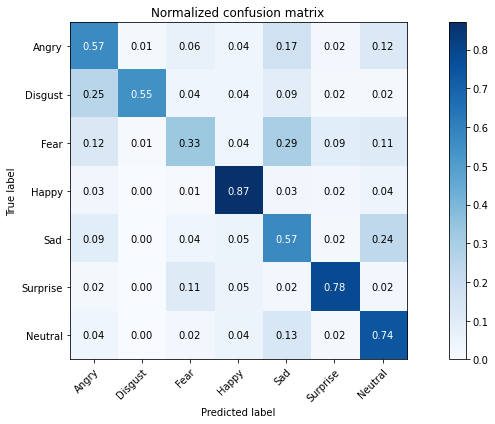

In [37]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()
